<a href="https://colab.research.google.com/github/ebrarkiziloglu/My-AI-Projects/blob/main/Cmpe_480_Decision_Tree_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment Description
Implement the decision tree learning algorithm with entropy. Run your algorithm in a dataset you download from web. Apply 5-fold cross-validation. Submit a single pdf file that includes:
* Information about dataset.
* Discuss use of 5-fold cross-validation.
* Provide error plots for training, validation and test datasets.
* Draw the final/best decision tree.
* Include your source code with comments.

## Implementation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Data Preparation
data = pd.read_csv("anime-list 4-sept-2022 update.csv")
data = data.dropna()
# Get rid of the unnecessary columns and missing data entries
col_names = ['rating', 'source', 'demographic', 'status', 'eps_avg_duration_in_min']
df = data[col_names]

# Fix the 'eps_avg_duration_in_min' values to the average durations. The ranges are as follows:
# [0, 10)   -> 5
# [10, 20)  -> 15
# [20, 30)  -> 25
# 30 -> 30
eps_durations = np.array([ (10 * int(1 + (val//10))) - 5 if val < 30.0 else 30 for val in df['eps_avg_duration_in_min'].values])
eps_durations.min()
df.loc[:, 'eps_duration'] = eps_durations
df = df.drop(columns='eps_avg_duration_in_min')

# Fix the 'rating' values such that an anime is considered GOOD if the rating is over 7/10 and BAD otherwise.
# [0, 7)  -> 'BAD'
# [7, 10) -> 'GOOD'
mapping_dict = {1: 'BAD', 2: 'GOOD'}
star_ratings = np.array([int(1 + (val) // 7) for val in df['rating'].values])
star_ratings = np.vectorize(mapping_dict.get)(star_ratings).astype(object)
df.loc[:, 'star_ratings'] = star_ratings
df = df.drop(columns='rating')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1604 entries, 0 to 2089
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   source        1604 non-null   object
 1   demographic   1604 non-null   object
 2   status        1604 non-null   object
 3   eps_duration  1604 non-null   int64 
 4   star_ratings  1604 non-null   object
dtypes: int64(1), object(4)
memory usage: 75.2+ KB


<ipython-input-16-5147417544f6>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'eps_duration'] = eps_durations


In [ ]:
# Following part consists of some utility functions and necessary objects to build the Tree:
def class_counts(dataset):
    # Counts the number of each type of label in the dataset.
    counts = {}  # label -> count.
    for data in dataset:
        # the label is adjusted to be the last column
        label = data[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

question_header = ['source', 'demographic', 'status', 'eps_duration']
class NodeQuestion:
    # A Question is used to split a dataset.
    # Records a 'column index' and a'column value'.
    # Each Decision Node includes a Question.
    def __init__(self, index, value):
        self.index = index
        self.value = value

    def match(self, example):
        # Compares the given feature value to the feature value in this question.
        feature = example[self.index]
        if self.__is_numeric(feature):
            return feature >= self.value
        else:
            return feature == self.value

    def __repr__(self):
        # A helper method to print the question in a readable format.
        condition = "=="
        if self.__is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s?" % (
            question_header[self.index], condition, str(self.value))

    def __is_numeric(self, value):
      return isinstance(value, int) or isinstance(value, float)

class DecisionTreeNode:
    # Nodes can be either a Decision or a Leaf Node.
    # The field 'is_leaf' determines the type of the Node.
    # A Decision Node includes a question, and two child nodes.
    # A Leaf node classifies data. It contains a dictionary of label -> count in the 'predictions' field.
    def __init__(self, question=None, true_child=None, false_child=None, is_leaf=False, rows=None):
        self.question = question
        self.true_child = true_child
        self.false_child = false_child
        self.is_leaf = is_leaf
        if is_leaf:
          self.predictions = class_counts(rows) if is_leaf else None
          self.majority_rating = max(self.predictions, key=lambda k: self.predictions[k]) if is_leaf else None
          self.count = sum(value for value in self.predictions.values())
        else:
          self.predictions, self.majority_rating, self.count = None, None, None
    # def print_leaf_node(self, indent):
    #   print (indent + "Predict", self.predictions)

# Decision Tree Class:
class DecisionTreeSolver():
    def __init__(self, min_samples_split=2, max_depth=5):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def fit(self, X, Y):
      dataset = np.concatenate((X, Y), axis=1)
      self.root = self.build_tree(dataset)
      return self.root

    def build_tree(self, dataset, curr_depth=0):
        # Builds the tree.
        X = dataset[:,:-1]
        Y = dataset[:,-1]
        num_samples, num_features = np.shape(X)
        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
          # Try partitioing the dataset on each of the unique data group,
          # calculate the information gain,
          # and return the question that produces the highest gain.
          gain, question = self.find_best_split(dataset)
          # Base case: no further info gain: Return a leaf
          if gain == 0:
              return DecisionTreeNode(is_leaf=True, rows=dataset)

          true_rows, false_rows = self.partition(dataset, question)
          # Build the true branch.
          true_child = self.build_tree(np.array(true_rows), curr_depth+1)
          # Build the false branch.
          false_child = self.build_tree(np.array(false_rows), curr_depth+1)

          # Return a Decision node.
          return DecisionTreeNode(question, true_child, false_child)
        return DecisionTreeNode(is_leaf=True, rows=dataset)

    def partition(self, dataset, question):
      # For each row in the dataset, check if it matches the given question. If
      # so, add it to 'true dataset', otherwise, add it to 'false dataset'.
      true_dataset, false_dataset = [], []
      for data in dataset:
          if question.match(data):
              true_dataset.append(data)
          else:
              false_dataset.append(data)
      return true_dataset, false_dataset

    def find_best_split(self, dataset):
      # Find the best question to ask by iterating over every feature
      # and calculating the information gain.
      best_gain = 0
      best_question = None
      parent_entropy = self.entropy(dataset)
      n_features = len(dataset[0]) - 1

      for col in range(n_features):  # for each feature
          values = set([row[col] for row in dataset])
          for val in values:  # for each value
              question = NodeQuestion(col, val)
              # try splitting:
              true_dataset, false_dataset = self.partition(dataset, question)
              # Skip this split if it doesn't divide the dataset
              if len(true_dataset) == 0 or len(false_dataset) == 0:
                  continue

              # Calculate the information gain from this split
              gain = self.info_gain(true_dataset, false_dataset, parent_entropy)

              # Use '>=':
              if gain >= best_gain:
                  best_gain, best_question = gain, question

      return best_gain, best_question

    def entropy(self, dataset):
      # Calculates entropy for a given group of data
      label_counts = class_counts(dataset)
      entropy = 0
      total_count = float(len(dataset))
      for label in label_counts:
          prob = label_counts[label] / total_count
          entropy -= prob * np.log2(prob)
      return entropy

    def info_gain(self, left_dataset, right_dataset, parent_entropy):
        # Information Gain.
        # Entropy of parent minus the weighted entropy of two child nodes
        p = float(len(left_dataset)) / (len(left_dataset) + len(right_dataset))
        return parent_entropy - p * self.entropy(left_dataset) - (1 - p) * self.entropy(right_dataset)

    def print_tree(self, node, indent="", depth=0):
      # Prints the decision tree model in a readable format

      # Base case: Leaf node
      if node.is_leaf:
        print (indent + "Predict", node.predictions)
        return

      # Print the question of the decision node
      print (indent + f'Depth {depth}: ' + str(node.question))

      # Print recursively the true branch
      print (indent + '--> True:')
      self.print_tree(node.true_child, indent + "  ", depth + 1)

      # Print recursively the false branch
      print (indent + '--> False:')
      self.print_tree(node.false_child, indent + "  ", depth + 1)

    def predict(self, X):
        # Predict a new dataset
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

    def make_prediction(self, x, node):
        # Predict a single data point
        if node.predictions != None:  # leaf node
          majority_rating = max(node.predictions, key=lambda k: node.predictions[k])
          return majority_rating
        if node.question.match(x):
          return self.make_prediction(x, node.true_child)
        else:
          return self.make_prediction(x, node.false_child)

def train_decision_tree(X_train, Y_train, min_samples_split=2, max_depth=5):
  solver = DecisionTreeSolver(min_samples_split, max_depth)
  my_tree = solver.fit(X_train, Y_train)
  return solver

def predict_decision_tree(trained_model, X_test):
  return trained_model.predict(X_test)

def calculate_accuracy(val_predictions, Y_val):
  true = 0
  false = 0
  for index, value in enumerate(val_predictions):
    if value == Y_val[index]:
      true += 1
    else:
      false += 1
  if true + false == 0:
    return -1
  accuracy = (true) / (true + false)
  return accuracy

In [ ]:
# Split the data into X and Y values, and train and test parts:
Y = df.iloc[:, -1].values.reshape(-1,1)
X = df.drop(columns=df.columns[-1]).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=41)
X = X_train
Y = Y_train
print(X.shape + Y.shape + X_test.shape + Y_test.shape)

(1443, 4, 1443, 1, 161, 4, 161, 1)


In [ ]:
# Perform 5-fold cross-validation
num_samples = len(X)
fold_size = num_samples // 5
print(f'num of samples is {num_samples} anf fold size is {fold_size}')
val_accuracies = []
training_accuracies = []
test_accuracies = []
best_val_accuracy = 0
best_tree = None
best_fold = -1
for fold in range(5):
    start_idx = fold * fold_size
    end_idx = (fold + 1) * fold_size if fold < 4 else num_samples
    # Extract the training and validation sets for this fold
    X_train = np.concatenate([X[:start_idx], X[end_idx:]], axis=0)
    Y_train = np.concatenate([Y[:start_idx], Y[end_idx:]], axis=0)
    X_val = X[start_idx:end_idx]
    Y_val = Y[start_idx:end_idx]

    # Train your decision tree on the training set
    trained_model = train_decision_tree(X_train, Y_train, min_samples_split=10, max_depth=5)
    # Evaluate the performance on the training set
    training_predictions = predict_decision_tree(trained_model, X_train)
    training_accuracy = calculate_accuracy(training_predictions, Y_train)
    training_accuracies.append(training_accuracy)
    # Evaluate the performance on the validation set
    val_predictions = predict_decision_tree(trained_model, X_val)
    val_accuracy = calculate_accuracy(val_predictions, Y_val)
    val_accuracies.append(val_accuracy)

    # Evaluate the performance on the test set
    test_predictions = predict_decision_tree(trained_model, X_test)
    test_accuracy = calculate_accuracy(test_predictions, Y_test)
    test_accuracies.append(test_accuracy)
    if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      best_tree = trained_model
      best_fold = fold
    print(f"Fold {fold + 1}: Validation Accuracy: {val_accuracy:.3f} and Training Accuracy: {training_accuracy:.3f}")
average_val_accuracy = np.mean(val_accuracies)
average_training_accuracy = np.mean(training_accuracies)
print(f"Average Validation Accuracy Across Folds: {average_val_accuracy:.3f}")
print(f"Average Training Accuracy Across Folds: {average_training_accuracy:.3f}")
print(f"Best Validation Accuracy Across Folds: {best_val_accuracy:.4f}")
print(f'The best fold number is Fold {best_fold}')
# Evaluate the performance on the test set
test_predictions = predict_decision_tree(best_tree, X_test)
test_accuracy = calculate_accuracy(test_predictions, Y_test)
print(f'Test accuracy for the best fold is {test_accuracy:.3f}')
print(f'Test accuracies are {test_accuracies}')

num of samples is 1443 anf fold size is 288
Fold 1: Validation Accuracy: 0.701 and Training Accuracy: 0.732
Fold 2: Validation Accuracy: 0.747 and Training Accuracy: 0.723
Fold 3: Validation Accuracy: 0.705 and Training Accuracy: 0.729
Fold 4: Validation Accuracy: 0.736 and Training Accuracy: 0.719
Fold 5: Validation Accuracy: 0.708 and Training Accuracy: 0.731
Average Validation Accuracy Across Folds: 0.719
Average Training Accuracy Across Folds: 0.727
Best Validation Accuracy Across Folds: 0.7465
The best fold number is Fold 1
Test accuracy for the best fold is 0.689
Test accuracies are [0.6832298136645962, 0.6894409937888198, 0.6583850931677019, 0.6894409937888198, 0.6894409937888198]


In [ ]:
print('Best Tree is')
best_tree.print_tree(best_tree.root, "", 0)

Best Tree is
Depth 0: Is demographic == Kids?
--> True:
  Depth 1: Is eps_duration >= 25?
  --> True:
    Depth 2: Is source == Original?
    --> True:
      Depth 3: Is eps_duration >= 30?
      --> True:
        Predict {'BAD': 1}
      --> False:
        Predict {'BAD': 19, 'GOOD': 2}
    --> False:
      Depth 3: Is source == Book?
      --> True:
        Predict {'GOOD': 3, 'BAD': 3}
      --> False:
        Depth 4: Is source == Manga?
        --> True:
          Predict {'GOOD': 3, 'BAD': 13}
        --> False:
          Depth 5: Is source == Picture book?
          --> True:
            Predict {'BAD': 1}
          --> False:
            Predict {'BAD': 29, 'GOOD': 13}
  --> False:
    Predict {'BAD': 29}
--> False:
  Depth 1: Is eps_duration >= 25?
  --> True:
    Depth 2: Is source == Manga?
    --> True:
      Depth 3: Is eps_duration >= 30?
      --> True:
        Predict {'BAD': 1}
      --> False:
        Depth 4: Is status == Airing?
        --> True:
          Predict {

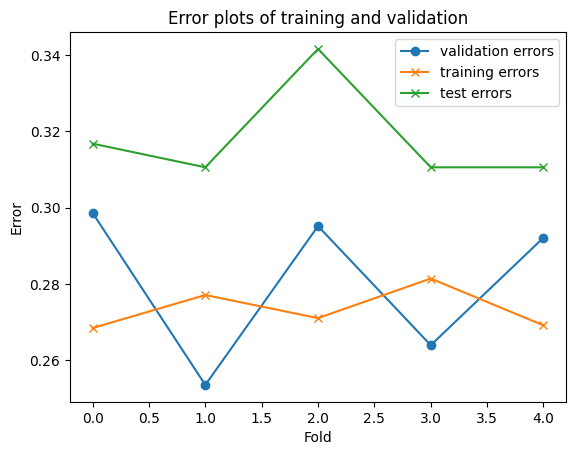

In [ ]:
# Error plots for training, validation and test datasets.
import matplotlib.pyplot as plt
val_errors = [1.0 - acc for acc in val_accuracies]
training_errors = [1.0 - acc for acc in training_accuracies]
test_errors = [1.0 - acc for acc in test_accuracies]
plt.plot(val_errors, label='validation errors', marker='o')
plt.plot(training_errors, label='training errors', marker='x')
plt.plot(test_errors, label='test errors', marker='x')
plt.xlabel('Fold')
plt.ylabel('Error')
plt.title('Error plots of training and validation')
plt.legend()
plt.show()